# Locations games avec références et côuts hétérogènes

In [1]:
import random 
from fractions import Fraction
import matplotlib.pyplot as plt
import numpy as np

In [2]:
message_deviations = "Entrez le nombre de déviations, par défaut il est de 30\nAppuyez sur la touche entrée si vous voulez laisser la valeur par défaut:\n"
message_echelle = "Sur une échelle de combien voulez-vous testez les références(30 par défaut)?\n"
message_success = "Tout est en norme avec la théorie" 

In [11]:
message_success = "Tout est en norme avec la théorie"  

def lancer_programme_ref_heterogene():
    """
    Lance un mini-programme en console pour simuler les équilibre de Nash en locations games avec références
    """
    #Demander les informations à l'utilisateur
    c = input("Entrez le côut de déviation pour chaque joueur en les séparants par des points virgules ; (il doit être compris entre 1/2 et 15 ): \n")
    c = np.array([Fraction(x) for x in c.split(";")])
    n = input(message_echelle)
    nbre_deviations = input(message_deviations)
    #Réécrire les paramètres selon l'entrée de l'utilisateur
    n= 100 if n=='' else int(n)
    nbre_deviations = 30 if nbre_deviations=='' else int(nbre_deviations)
    #Lancer la simulation
    tester_equilibres_ref_heterogene(c=c,n=n,nbre_deviations= int(nbre_deviations))
    
def tester_equilibres_ref_heterogene(c,n=100,nbre_deviations=30):
    
    grille =np.array([Fraction(x,n) for x in range(0,n+1)]) 
 
    references = []
    
    for r1 in grille :
        #Récupérer uniquement les r2>r1
        grille_r2 = list(filter(lambda x: x>=r1,grille))
        for r2 in grille_r2:
            references.append([r1,r2])
            
    references = np.array(references)
    
    resultats_dict =  verifier_profile_ref_heterogene(c,references,nbre_deviations)
    
    resultats=resultats_dict["correct"]
    
    resultats_incorrect = resultats_dict["incorrect"]
    
    x= np.concatenate((resultats[:,0],1-resultats[:,0]),0)
    y =np.concatenate((resultats[:,1],1-resultats[:,1]),0)
    col =np.concatenate((resultats[:,2],resultats[:,2]),0)
    
    #Représentation du graphique
    plt.scatter(x,y,c=col,s=1)
    """plt.title("Nuage de points des références",{
        "fontsize":16,
        "fontweight":25,
        "color": 'r'
    })"""
    plt.xlabel("Références R1")
    plt.ylabel("Références R2")
    plt.show()
    print(message_success)
    
    if resultats_incorrect.size>0:
        print(f'Il y a {resultats_incorrect.shape[0]} pour lesquels on a pas trouvé de déviations : \n',resultats_incorrect)

In [12]:
def verifier_profile_ref_heterogene(c,refs,nbres_deviation =  10):
    """
    Duopole avec reference
        Permet de vérifier la théorie sur l'existence des équilibres de Nash
    Paramètres:
        c: int
            Le côut de déviation, est un entier ou décimal compris entre 0.5 et 15
        refs: list, tuple
            les références des joueurs en décimales ou fraction compris entre 0 et 1 
        nbre_deviation: Représente le nombre de déviation simulé. la valeur par défaut est 10 000
    return: None
    """

    
    #Calcul des bornes
    bornes = np.apply_along_axis(calculs_bornes_heterogene,1,refs,c)
    
    
    #sélectionner les bornes du cas 1
    selection_cas1 = bornes[:,1]>=bornes[:,2]
    
    bornes_cas1 = bornes[selection_cas1]
    
    refs_cas1 =  refs[selection_cas1]

    
    #sélectionner les bornes du cas 2
    bornes_cas2 = bornes[np.logical_not(selection_cas1)]
    refs_cas2 =  refs[np.logical_not(selection_cas1)]
    
    result_cas1 = verifier_cas1_heterogene(c=c,refs=refs_cas1 ,bornes=bornes_cas1,nbres_deviation=nbres_deviation)
    

    result_cas2 = verifier_cas2_heterogene(c=c,refs=refs_cas2,bornes=bornes_cas2,nbres_deviation=nbres_deviation)
    
    return {
        "correct": np.concatenate((result_cas1["correct"],result_cas2["correct"]),axis=0),
        "incorrect":np.concatenate((result_cas1["incorrect"],result_cas2["incorrect"]),axis=0)
    }

In [13]:
def calculs_bornes_heterogene(references,c):
    """
    Retourne les bornes de décision d'équilibre de Nash pour les joueurs, ie 
    r1  - 1/4c1,r1 + 1/4c1, r2 - 1/4c2,r2 + 1/4c2
    
    paramètres:
        references: list, tuple
            les références des joueurs en décimales ou fraction compris entre 0 et 1
    return: tuple
        retourne les bornes        
    """

    refs = sorted(references)
    
    is_sorted = refs[0]==references[0]
    
    c1 = c[0 if is_sorted else 1]
    c2 = c[1 if is_sorted else 0]
    
    delta1 = Fraction(1,4*c1)
    delta2 = Fraction(1,4*c2)
    
    return refs[0] - delta1,refs[0] + delta1 ,refs[1] - delta2,refs[1] + delta2

In [14]:
def verifier_cas1_heterogene(c,refs,bornes,nbres_deviation):
    """
    Duopole avec références:
        Permet de vérifier si le profil (1/2,1/2) est un équilibre de Nash ou pas
    Paramètres:
        c: Le côut de déviation, est un entier ou décimal compris entre 0.5 et 15
        refs: np.array au format (n,2) 
            les références décimales ou fraction compris entre 0 et 1
        bornes: np.array au format (n,2)
            Représente les bornes associées aux différents couple de références
        nbre_deviation: Représente le nombre de déviation simulé 
    return: dict
        les clés sont corrects: pour les références qui matchent bien avec la théorie
        incorrects pour les références dont des déviations appropriées n'ont pas été trouvée pour l'équilibre associée
    """
    
    #Sélectionner les bornes correspondant au cas où 1/2 est équilibre
    selecteur_equilibre = \
        (bornes[:,2]<=Fraction(1,2)) & \
        (Fraction(1,2)<=bornes[:,3]) & \
        (bornes[:,0]<=Fraction(1,2)) & \
        (Fraction(1,2)<=bornes[:,1])
    
    #sélectionner les références de l'équilibre
    refs_equilibre = refs[selecteur_equilibre]
    
    #Créer les actions notamment 1/2 pour chaques couple de référence
    actions = np.full(shape=refs_equilibre.shape, fill_value=Fraction(1,2))

    #Récupéer les résultats des déviations
    result_deviations = joueurs_peut_devier_ref_heterogene(c,actions,refs_equilibre,nbres_deviation)

    if np.any(result_deviations):
        #Aucune déviation favorable ne doit être trouvée
        return print("danger de mort 1 1")
    else:
        #Définir les courleurs et rassembler le tout dans un tableau
        colors_equilibre = np.full(shape=(refs_equilibre.shape[0],1), fill_value="orange")
        out_equilibre = np.concatenate((refs_equilibre,colors_equilibre),axis=1)
        
    
    #Le cas où 1/2,1/2 n'est pas un équilibre    
    
    #Sélectionner les références non équilibres
    refs_non_equilibre = refs[np.logical_not(selecteur_equilibre)]    
    
    #Créer les actions 1/2 correspondantes
    actions = np.full(shape=refs_non_equilibre.shape, fill_value=Fraction(1,2))
    
    #faire les déviations pour vérifier qu'on trouve bien des déviations favorable
    result_deviations = joueurs_peut_devier_ref_heterogene(c,actions,refs_non_equilibre,nbres_deviation,False)

    #récupérer les références pour qui des déviations ont été trouvées
    result_corrects = refs_non_equilibre[result_deviations]
        
    #Choisir les couleurs correspondantes
    colors_non_equilibre = np.full(shape=(result_corrects.shape[0],1), fill_value="w")
    out_non_equilibre = np.concatenate((result_corrects,colors_non_equilibre),axis=1)
    
    return {
            "correct": np.concatenate((out_equilibre,out_non_equilibre),axis=0),
            "incorrect": refs_non_equilibre[np.logical_not(result_deviations)] #c'est possible de ne pas trouver des déviations appropriées 
           } 

def verifier_cas2_heterogene(c,refs,bornes,nbres_deviation):
    """
    Duopole avec références:
        Permet de vérifier si le profil (r1 + 1/4c, r2 - 1/4c) est un équilibre de Nash ou pas
    Paramètres:
        c: Le côut de déviation, est un entier ou décimal compris entre 0.5 et 15
        refs: np.array au format (n,2) 
            les références décimales ou fraction compris entre 0 et 1
        bornes: np.array au format (n,2)
            Représente les bornes associées aux différents couple de références
        nbre_deviation:int
            Représente le nombre de déviation simulé 
    return: dict
        les clés sont corrects: pour les références qui matchent bien avec la théorie
        incorrects pour les références dont des déviations appropriées n'ont pas été trouvée pour l'équilibre associée
    """
        
    #Calculer les équations 1 et 2
    c1 = c[0]
    c2 = c[1]
    
    delta1 = Fraction(1,4*c1)
    delta2 = Fraction(1,4*c2)
    
    eq1 = c1*(refs[:,1]- refs[:,0])**2 -2*c1*delta2*(refs[:,1] - refs[:,0]) + Fraction(1,2)*(refs[:,0]+delta1) + Fraction(3,2)*(refs[:,1]-delta2)+ c1*(delta2**2-delta1**2) - 1
    eq2= c2*(refs[:,1]- refs[:,0])**2 -2*c2*delta1*(refs[:,1] - refs[:,0]) - Fraction(1,2)*(refs[:,1]-delta2) - Fraction(3,2)*(refs[:,0]+delta1)- c2*(delta2**2-delta1**2) + 1

    #Selectionner les bornes équilibres
    selecteur_equilibre = (eq1>=0)&(eq2>=0)

    equilibres = bornes[selecteur_equilibre,1:3]

    #Les références associées
    refs_equilibre = refs[selecteur_equilibre]

    #Récupérer les déviations 
    result_deviations = joueurs_peut_devier_ref_heterogene(c=c,actions=equilibres,
                                                refs=refs_equilibre,
                                               nbre_deviation=nbres_deviation)

    if np.any(result_deviations):
        #ON ne doit pas trouver de déviation favorable
        return print("danger de mort 2 1")
    else:
        colors_equilibre = np.full(shape=(refs_equilibre.shape[0],1), fill_value="b")

        out_equilibre = np.concatenate((refs_equilibre,colors_equilibre),axis=1)


        

    #Selectionner les références non équilibre            
    refs_non_equilibre = refs[np.logical_not(selecteur_equilibre)]

    actions = bornes[np.logical_not(selecteur_equilibre)]

    result_deviations = joueurs_peut_devier_ref_heterogene(c=c,
                                                actions=actions,
                                                refs= refs_non_equilibre,
                                                nbre_deviation= nbres_deviation,
                                                          tester_equilibre=False)

    #récupérer les références avec déviation favorable
    result_corrects = refs_non_equilibre[result_deviations]

    #Choisir les couleurs correspondantes
    colors_non_equilibre = np.full(shape=(result_corrects.shape[0],1), fill_value="w")
    out_non_equilibre = np.concatenate((result_corrects,colors_non_equilibre),axis=1)

    return {
            "correct": np.concatenate((out_equilibre,out_non_equilibre),axis=0),
            "incorrect": refs_non_equilibre[np.logical_not(result_deviations)]
           }

In [15]:

def joueurs_peut_devier_ref_heterogene(c,actions,refs,nbre_deviation,tester_equilibre=True):
    """
    Retourne une valeur indiquant si un joueur, a une déviation profitable ou non
    Paramètres:
      c: int, float
            Le côut de déviation doit compris entre 0.5 et 15
        actions: list, tuple
            le profil d'actions des joueurs
        refs: list, tuple
            les références des joueurs en décimales ou fraction compris entre 0 et 1 
    return: boolean,dict
        Retourne False, si aucun joueurs n'a de déviation profitable possible
        Un dict, si un joueur a une déviation profitable possible
    """
    #Le paiement des joueurs à l'équilibre
    
    values = np.concatenate((refs,actions),axis=1)
    
    result_deviations  = np.apply_along_axis(simuler_deviation_heterogene,1,values,c,nbre_deviation,tester_equilibre)
    
    return result_deviations
    
def simuler_deviation_heterogene(values,c,nbre_deviation,tester_equilibre):
    """
    Paramètres:
        values: list, tuple à 4 éléments les [r1,r2,action1,action2]
            les références,les actions et les coûts des joueurs en décimales ou fraction 
        nbre_deviation:int
            Représente le nombre de déviation simulé 
        tester_equilibre: boolean
            Indique si le profil à tester est censé être un équilibre
    return: boolean
        true si une déviation favorable a été trouvé pour un joueur
        false sinon
    """
    
    refs = values[0:2]
    
    actions = values[2:4]
         
    
    #Tirer au hasard des déviations
    deviations = np.random.uniform(0,1,size=(1,round(nbre_deviation-8)))
    
    #Convertir en fraction 
    deviations = np.apply_along_axis(lambda x : Fraction(x[0]),axis=0,arr=deviations)
    
    #Garantir les déviations locales pour les déviations pour ldes cas particuliers
    deviations_locales =np.array([actions[0]-Fraction("10e-12"),actions[0]+Fraction("10e-12"),
                                            actions[1]-Fraction("10e-12"),actions[1]+Fraction("10e-12")
                                         ]) 

    #Calculer le paiement à l'équilibre
    paiements_equilibre  = paiement_ref_heterogene(values,c)
     
    if tester_equilibre:
        

        #Joindre les déviations locales avec celles aléatoires
        deviations = np.concatenate((deviations_locales,deviations,deviations_locales),0)
        
        #Tirer au hasard un joueur pour deviations_locales_joueur1la déviation
        nombre_de_1 = sum(np.random.randint(0,2,size = deviations.size))
    
        #Créer un tableau avec les déviations
        profil_deviation = np.array(np.broadcast_to(values,shape=(deviations.size,values.size))) 

        #Faire dévier aléatoirement les joueurs 1 et 2
        profil_deviation[:nombre_de_1,2]=deviations[:nombre_de_1]

        profil_deviation[nombre_de_1:,3]=deviations[nombre_de_1:]
        

        #Calculer les paiements après déviations
        paiements_deviation= np.apply_along_axis(paiement_ref_heterogene,1,profil_deviation,c)
    
        
        result_deviation_1 = paiements_equilibre[0]<paiements_deviation[:nombre_de_1,0]

        result_deviation_2=paiements_equilibre[1]<paiements_deviation[nombre_de_1:,1]

        return np.any(result_deviation_1) or np.any(result_deviation_2)
    else: #Si le profil n'est pas un équilibre on teste d'abord les déviations locales
        
        profil_deviation = np.array(np.broadcast_to(values,shape=(deviations_locales.size*2,values.size)))  
        
        nombre_de_1 = deviations_locales.size
        
                #Faire dévier aléatoirement les joueurs 1 et 2
        profil_deviation[:nombre_de_1,2]=deviations_locales
        
        profil_deviation[nombre_de_1:,3]=deviations_locales
        
        #Calculer les paiements après déviations
        paiements_deviation= np.apply_along_axis(paiement_ref_heterogene,1,profil_deviation,c)
        
        result_deviation_1 = paiements_equilibre[0]<paiements_deviation[:nombre_de_1,0]

        result_deviation_2=paiements_equilibre[1]<paiements_deviation[nombre_de_1:,1]
        
        if np.any(result_deviation_1) or np.any(result_deviation_2):
            return True
        #Si la déviation locale ne suffit pas pour prouver que le profil n'est pas un équilibre on teste celle globale 
        else:
                    #Tirer au hasard un joueur pour deviations_locales_joueur1la déviation
            nombre_de_1 = sum(np.random.randint(0,2,size = deviations.size))

            #Créer un tableau avec les déviations
            profil_deviation = np.array(np.broadcast_to(values,shape=(deviations.size,values.size))) 
            
   
            #Faire dévier aléatoirement les joueurs 1 et 2
            profil_deviation[:nombre_de_1,2]=deviations[:nombre_de_1]

            profil_deviation[nombre_de_1:,3]=deviations[nombre_de_1:]


            #Calculer les paiements après déviations
            paiements_deviation= np.apply_along_axis(paiement_ref_heterogene,1,profil_deviation,c)


            result_deviation_1 = paiements_equilibre[0]<paiements_deviation[:nombre_de_1,0]

            result_deviation_2=paiements_equilibre[1]<paiements_deviation[nombre_de_1:,1]
            
            return np.any(result_deviation_1) or np.any(result_deviation_2)
        
def paiement_ref_heterogene(values,c):
    """
    Calcule le paiement des deux joueurs et renvoie le résultat dans l'ordre des actions
    Paramètres:
        values: list, tuple à 4 éléments les [r1,r2,action1,action2]
            les références des joueurs en décimales ou fraction compris entre 0 et 1 
    return: list [paiement de r1, paiement de r2]
        les paiements des joueurs
    """
    
    refs = values[0:2]
    
    actions = values[2:4]
    #Trier les actions des joueurs
    actions_triees= sorted(actions)

    
    #Vérifier si les actions étaient déjà dans le bon ordre
    is_ordered = actions_triees[0] == actions[0]

    c1 = c[0 if is_ordered else 1]
    c2 = c[1 if is_ordered else 0]
    
    r1= refs[0 if is_ordered else 1]
    r2=refs[1 if is_ordered else 0]
    
    #Calculer la moyenne des actions
    moyenne = (actions_triees[0]+actions_triees[1])/2 
    
    #calculer le paiement du joueur ayant joué la plus petite action
    paiement_1 = moyenne - c1*(actions_triees[0]-r1)**2
    
    #Calculer le paiement du joueur ayant joué la plus grande action
    paiement_2 = 1- moyenne - c2*(actions_triees[1]-r2)**2
    
    """
    Selon que la liste était déjà triée ou pas on retourne les paiements selon l'ordre dans lequel 
    les actions fût envoyées
    """
    if is_ordered:
        return np.array([paiement_1,paiement_2])
    else :
        return np.array([paiement_2,paiement_1])

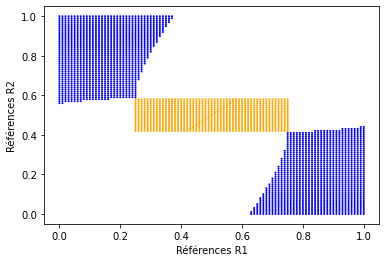

Tout est en norme avec la théorie


In [17]:
tester_equilibres_ref_heterogene([1,3],100,30)

Entrez le côut de déviation pour chaque joueur en les séparants par des points virgules ; (il doit être compris entre 1/2 et 15 ): 
1;10
Sur une échelle de combien voulez-vous testez les références(30 par défaut)?
250
Entrez le nombre de déviations, par défaut il est de 30
Appuyez sur la touche entrée si vous voulez laisser la valeur par défaut:



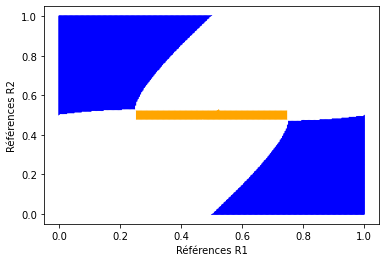

Tout est en norme avec la théorie


In [16]:
lancer_programme_ref_heterogene()